# Capítulo 10 Data Science do Zero - Visão Computacional e Deep Learning

## Classificação de Imagens utitlizando Transfer Learning
### Kaggle Dataset Competition: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

![dogs-cat](imagens/dogs-cats.png "dogs-cats")

##### verificando a base de dados

In [1]:
import os,random

In [2]:
print(os.listdir("datasets"))

['test', 'train']


In [3]:
print(os.listdir("datasets/train")[:10])

['dog.145.jpg', 'cat.22.jpg', 'cat.58.jpg', 'dog.107.jpg', 'dog.146.jpg', 'dog.136.jpg', 'dog.189.jpg', 'dog.24.jpg', 'cat.158.jpg', 'cat.198.jpg']


##### diretorios de imagens

In [4]:
train_dir = 'datasets/train'
test_dir = 'datasets/test'

##### listas com as imagens de treino e test

In [5]:
train_imgs = ['datasets/train/{}'.format(i) for i in os.listdir(train_dir)]
test_imgs = ['datasets/test/{}'.format(i) for i in os.listdir(test_dir)]

In [6]:
print("Quantidade de imagens de treino:{train} e test:{test}".format(train=len(train_imgs),test=len(test_imgs)))

Quantidade de imagens de treino:400 e test:100


##### aleatorizando as imagens de treinamento

In [7]:
random.shuffle(train_imgs)

In [8]:
print(train_imgs[:10])

['datasets/train/dog.199.jpg', 'datasets/train/cat.95.jpg', 'datasets/train/cat.130.jpg', 'datasets/train/dog.184.jpg', 'datasets/train/cat.3.jpg', 'datasets/train/dog.89.jpg', 'datasets/train/dog.196.jpg', 'datasets/train/dog.173.jpg', 'datasets/train/dog.13.jpg', 'datasets/train/dog.50.jpg']


##### importando as bibliotecas necessárias

In [9]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

##### definindo as dimensões das imagens de entrada

In [10]:
nrows = 150
ncolumns = 150
channels = 3

##### função para processamento das imagens e classes

###### efetuando o resize nas imagens e definindo os valores inteiros para as classes

In [11]:
def read_and_process_image(list_of_images):  
    X = []
    y = []
    
    for image in list_of_images:
        image_ = Image.open(image)
        X.append(np.asarray(image_.resize((nrows,ncolumns))))
        
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)
    
    return X, y

In [12]:
X, y = read_and_process_image(train_imgs)

##### transformando a lista de imagens e classes em array

In [13]:
X = np.array(X)
y = np.array(y)

##### visualizando algumas imagens

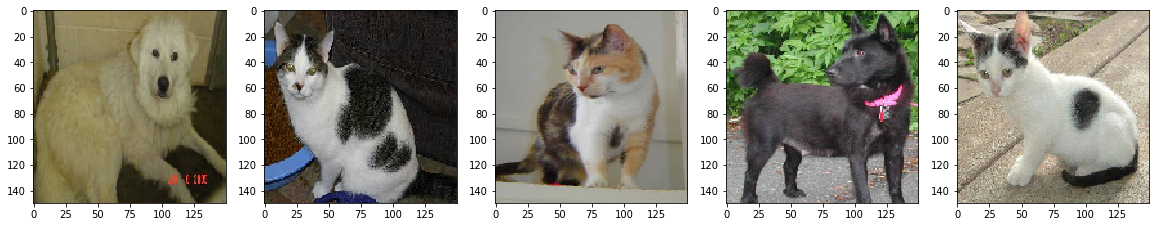

In [14]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

##### separando as imagens os dados em treino e test

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

Now lets create our model.

##### instalando as bibliotecas keras e tensorflow

In [16]:
!pip install keras

In [17]:
!pip install tensorflow

##### Importando o modelo pre-treinado ImageNet

In [18]:
from keras.applications import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


##### Verificando a arquitetura da rede

In [19]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

##### importando a biblioteca keras para criar a rede

In [20]:
from keras import layers
from keras import models

##### criando o modelo utilizando a rede convolucional como base

In [21]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

##### Verificando novamente a arquitetura da rede

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


##### Verificando o numero de pesos a ajustar sem utilizar a rede pré-treinada e após..

In [23]:
print('Número de pesos ajustáveis sem utilizar a rede convolucional:', len(model.trainable_weights))
conv_base.trainable = False
print('Número de pesos ajustáveis utilizando a rede convolucional::', len(model.trainable_weights))

Número de pesos ajustáveis sem utilizar a rede convolucional: 492
Número de pesos ajustáveis utilizando a rede convolucional:: 4


##### Criação dos conjuntos de dados de treino e test utilizando Data Augmentation para prevenir overfitting

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

##### Criando um modelo binário para treinar as nossas imagens

In [25]:
from keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


KeyboardInterrupt: 

##### Salvando o modelo e pesos em disco

In [ ]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

##### Salvando o arquivo de historico em disco

In [ ]:
import pickle

In [ ]:
f = open('history.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

##### Carregando o modelo a partir do disco

In [29]:
from keras.models import load_model

In [26]:
import pickle

In [27]:
model = load_model("model_keras.h5")

Instructions for updating:
Use tf.cast instead.


/home/felipe/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


##### Carregando o arquivo de historico a partir do disco

In [30]:
f = open('history.pckl', 'rb')
historico = pickle.load(f)
f.close()

##### Visualizando as métricas do modelo

In [39]:
import matplotlib.pyplot as plt

acc = historico['acc']
val_acc = historico['val_acc']
loss = historico['loss']
val_loss = historico['val_loss']
epochs = range(1, len(acc) + 1)

##### Acurácia de treino e teste

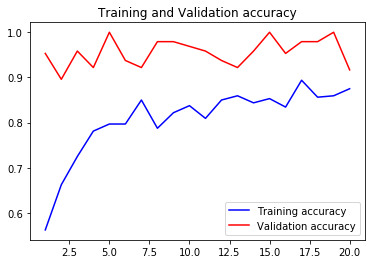

In [40]:
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

##### Função de perda de treino e teste

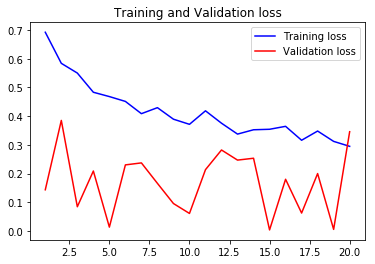

In [41]:
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

##### Função para suavizar os dados e melhorar a visualização

In [42]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

##### Acurácia de treino e teste

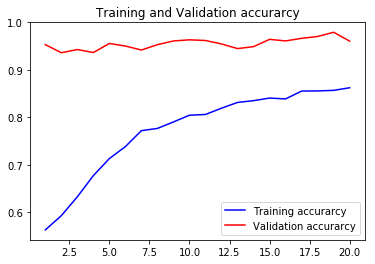

In [43]:
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

##### Testando os resultados de predição

###### Selecionando 10 imagens a partir do conjunto de teste

In [44]:
X_test, y_test = read_and_process_image(test_imgs[0:10])

###### transformando a lista de imagens em array e aplicando a rescala dos pixels

In [45]:
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

###### plotando as imagens e suas respectivas classes

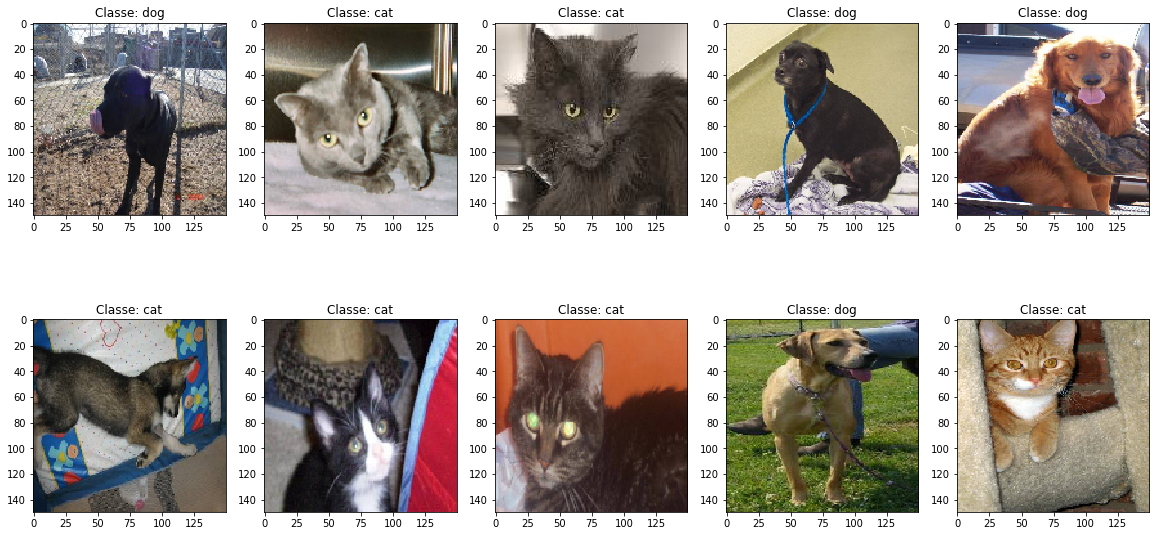

In [46]:
i = 0
columns = 5
text_labels = []

plt.figure(figsize=(20,10))

for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict_classes(batch)
    if pred == 1:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('Classe: ' + text_labels[i])
    
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()